This notebook is for developing suplemental figure 4.

It works together with scripts "deploy_shuffle_clustering.py" and "run_shuffle_clustering.py" which are in vba repo, to generate shuffled datasets, coclustering matrices and labels for each type of shuffle.

For the scope of supplemental figure 4, I will only use "experience" and "experience_within_cell" shuffle types for figures.

This version of the notebook aims at figuring out how to stabilize shuffle comparisons.

The issue is that comparing sizes of clusters when shuffled data produced clusters of drastically different sizes doesnt make sense. 

While probability of seeing the cell may be best computed with or without restrictions.

First I will try to implement resetricitons for both size and probability measurements. 


In [1]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\data_access\loading.py:53: UserWarning: failed to set up LIMS/mtrain credentials
'MTRAIN_DBNAME'

internal AIBS users should set up environment variables appropriately
functions requiring database access will fail
  warnings.warn(warn_string)


In [2]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [6]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


3921 cells in matched cells table


In [7]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [8]:
# set params for saving
folder = '220811_all_fix1'
file_dir = '220627_shuffle_test/files'

In [9]:
base_dir = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [10]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

#### Load original feature matrix,, meta data and cluster labels

In [11]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(base_dir,file_dir, filename), key='df')

In [12]:
filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [13]:
filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
original_cluster_labels = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [14]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].index.values
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

In [15]:
original_cluster_labels.head(2)

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2


#### compute mean dropout scores for original data

In [16]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df)
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    if cre_line == 'Slc17a7-IRES2-Cre':
        print('changing stuff')
        mean_dropout_scores=mean_dropout_scores.rename(columns= {4:5,5:4})
        mean_dropout_scores = mean_dropout_scores.reindex(sorted(mean_dropout_scores), axis=1)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

changing stuff


In [17]:
original_min_max = {}
for cre_line in cre_lines:
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    min_cluster = cluster_df[['cluster_id']].value_counts().min()
    max_cluster = cluster_df[['cluster_id']].value_counts().max()
    original_min_max[cre_line] = [min_cluster, max_cluster]

    print(100/len(cluster_df)*min_cluster)
    print(100/len(cluster_df)*max_cluster)

3.23653962492438
22.081064730792498
3.0
33.0
2.6506024096385543
22.40963855421687


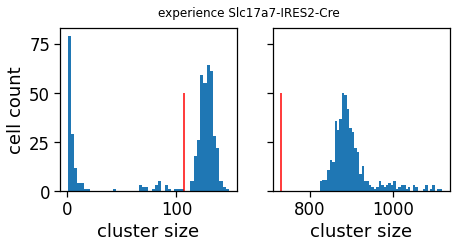

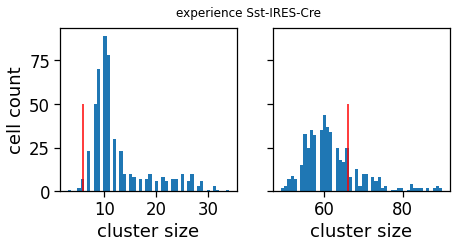

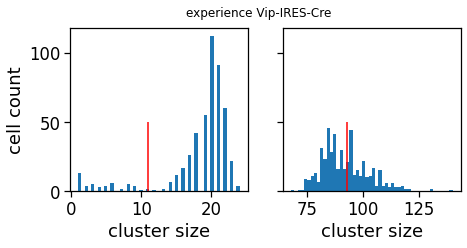

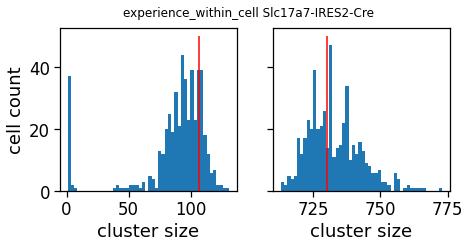

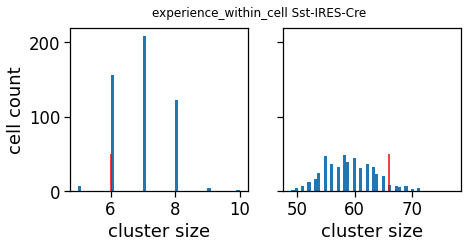

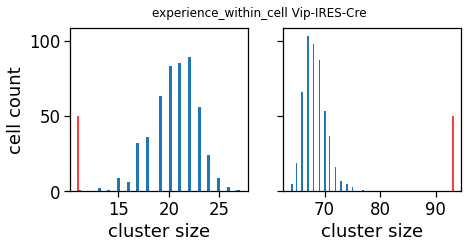

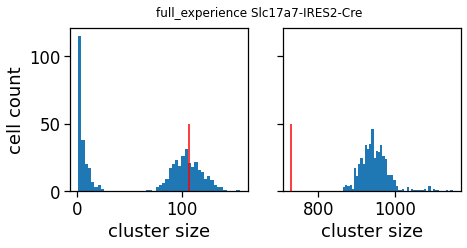

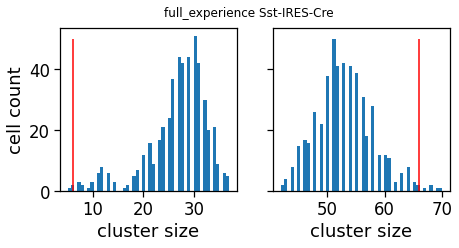

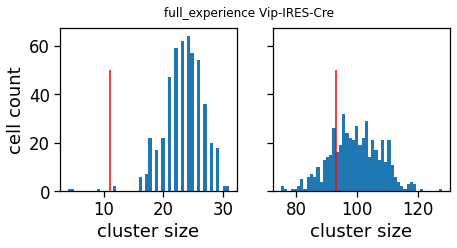

In [79]:
### plot minimum and maximum cluster size in the shuffles
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         min_clusters = []
#         max_clusters = []
#         for n, n_boot in enumerate(n_boots):
#             x = shuffle_type_labels[shuffle_type][cre_line][n][['cluster_id']].value_counts().min()
#             min_clusters.append(x)
            
#             y = shuffle_type_labels[shuffle_type][cre_line][n][['cluster_id']].value_counts().max()
#             max_clusters.append(y)
#         fig, ax = plt.subplots(1,2, figsize = (7,3), sharey = 'row')
#         ax[0].hist(min_clusters, 50)
#         ax[0].vlines(x=original_min_max[cre_line][0], ymin=0, ymax=50, color='r')
#         ax[0].set_ylabel('cell count')
#         ax[0].set_xlabel('cluster size')
#         ax[1].hist(max_clusters, 50)
#         ax[1].vlines(x=original_min_max[cre_line][1], ymin=0, ymax=50, color='r')
#         ax[1].set_xlabel('cluster size')
#         plt.suptitle(shuffle_type +' ' + cre_line)
#         utils.save_figure(fig, figsize = (7,3), save_dir=save_dir, folder='',
#                           fig_title=f'min_max_cluster_size_{cre_line}_{shuffle_type}')
            

In [18]:
min_cluster_size = {}
for cre_line in cre_lines:
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    # let's do 2 percent
    min_cluster=len(cluster_df)/100*2
    min_cluster_size[cre_line]=round(min_cluster)

In [19]:
min_cluster_size

{'Slc17a7-IRES2-Cre': 66, 'Sst-IRES-Cre': 4, 'Vip-IRES-Cre': 8}

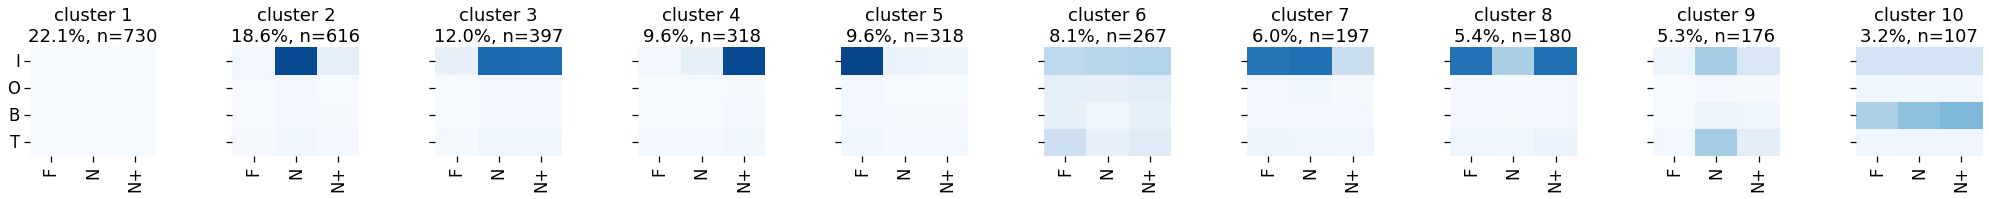

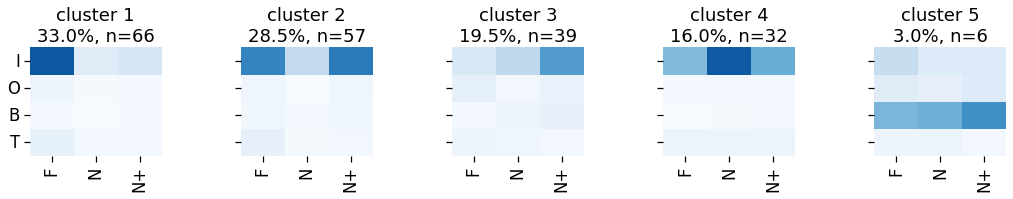

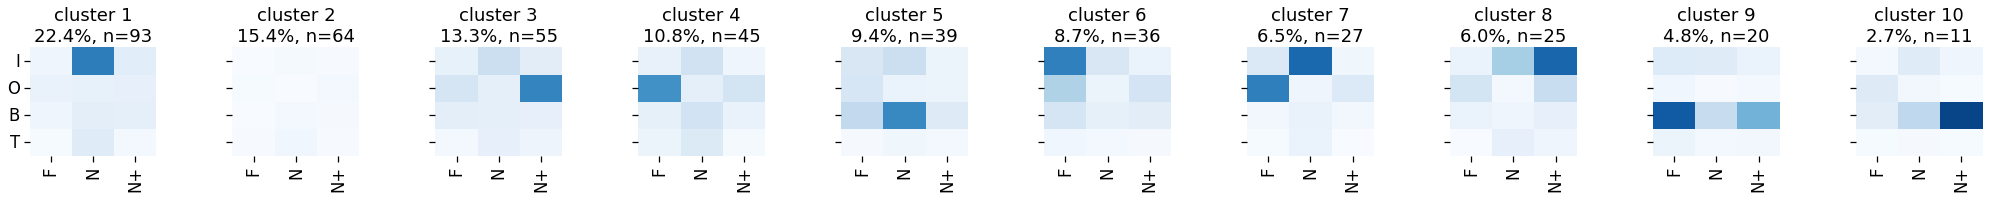

In [20]:
# plot original clusters
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original',
                                )


#### load shuffled datasets into one dictionary

In [21]:
shuffle_types = ['experience', 'experience_within_cell','full_experience']
# randomize 150 samples of shuffled data
# n_boots = np.random.randint(0, 500, 150)
n_boots = np.arange(500)

#### load cluster labels for each dataset into one dictionary

In [24]:
%%time
shuffle_type_labels = {}
shuffle_nboots = {}
for shuffle_type in shuffle_types:
    cre_labels_shuffled = {}
    cre_nboots = {}
    for cre_line in cre_lines:
        nb_labels_shuffled = {}
        min_cluster_check = min_cluster_size[cre_line]
        
        index = 0; n_boots_sel = []                  
        for n, n_boot in enumerate(n_boots):
            nb_filename ='{}_{}_nb{}_cluster_labels.h5'.format(cre_line, shuffle_type, n_boot) 
            full_filename = os.path.join(base_dir, file_dir, nb_filename)
            tmp_labels = pd.read_hdf(full_filename, key = 'clustered_df')
            
            # check size clusters
            min_cluster = tmp_labels[['cluster_id']].value_counts().min()
            if min_cluster>= min_cluster_check:
                nb_labels_shuffled[index] =  tmp_labels
                index = index+1
                n_boots_sel.append(n_boot)
            #else:
            #    print('min cluster is too small')
        
        #print(shuffle_type, cre_line, index)
        cre_labels_shuffled[cre_line] = nb_labels_shuffled
        cre_nboots[cre_line] = [index-1, n_boots_sel]
    shuffle_type_labels[shuffle_type] = cre_labels_shuffled
    shuffle_nboots[shuffle_type] = cre_nboots
    

min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small
min cluster is too small


In [25]:
%%time
# this takes a few minutes
shuffle_type_df = {}
for shuffle_type in shuffle_types:
    cre_df_shuffled = {}
    for cre_line in cre_lines:
        nb_shuffled = {}
        n_boots = shuffle_nboots[shuffle_type][cre_line][1]
        for n, n_boot in enumerate(n_boots):
            nb_filename ='{}_{}_nb{}.h5'.format(cre_line, shuffle_type, n_boot)
            
            try:
                nb_shuffled[n] = pd.read_hdf(os.path.join(base_dir, file_dir, nb_filename), key = 'df')
            except:
                print(f'did not find nboot {n_boot}')
        cre_df_shuffled[cre_line] = nb_shuffled
    shuffle_type_df[shuffle_type] = cre_df_shuffled

Wall time: 4min 8s


#### compute mean dropout scores for shuffled dfs


In [28]:
shuffle_type_mean_dropout_scores = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        n_boots = shuffle_nboots[shuffle_type][cre_line][1]
        for n, n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores
        cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores[shuffle_type] = cre_mean_dropout_scores_shuffled

In [ ]:
### this takes a lot of time so run it at your own risk
### plot clusters
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        n_boots = shuffle_nboots[shuffle_type][cre_line][1]
        for n, n_boot in enumerate(n_boots):
            feature_matrix = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n].set_index('cell_specimen_id')
            sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
            vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                                   sort_order=sort_order, save_dir=save_dir, folder='shuffled_plots', 
                                        suffix='_nb'+str(n_boot)+'_'+shuffle_type, formats=['.png'])
            plt.close('all')

### compute SSE

In [30]:
shuffle_type_SSE = {}
for shuffle_type in shuffle_types:
    cre_SSE = {}
    for cre_line in cre_lines:
        nb_sse = {}
        original_df = cre_mean_dropout_scores[cre_line]
        n_boots = shuffle_nboots[shuffle_type][cre_line][1]
        for n, n_boot in enumerate(n_boots):
            shuffled_df = shuffle_type_mean_dropout_scores[shuffle_type][cre_line][n]
            sse = vba_clust.compute_SSE(original_df, shuffled_df)
            nb_sse[n] = sse
        cre_SSE[cre_line] = nb_sse
    shuffle_type_SSE[shuffle_type] = cre_SSE
        



### get cluster mapping

In [31]:
shuffle_type_SSE_mapping = {}
for shuffle_type in shuffle_types:
    cre_SSE_mapping = {}
    for cre_line in cre_lines:
        nb_sse_mapping = {}
        nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
        cluster_mapping = vba_clust.get_cluster_mapping(nb_matrix, threshold = 0.09)
        cre_SSE_mapping[cre_line] = cluster_mapping
    shuffle_type_SSE_mapping[shuffle_type] = cre_SSE_mapping


#### need to plot aligned clusters into one folder
Each matched cluster, correlation coeff between matched clusters and original cluster, and mean matched cluster

In [32]:
#create unstacked mean dropout scores for ach cluster for plotting
shuffle_type_mean_dropout_scores_unstacked = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled_unstacked = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        n_boots = shuffle_nboots[shuffle_type][cre_line][1]
        for n,n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            #cluster_df = cluster_df.rename(mapper={'labels':'cluster_id'}, axis=1)
            mean_dropout_scores_unstacked = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df, stacked=False)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores_unstacked
        cre_mean_dropout_scores_shuffled_unstacked[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores_unstacked[shuffle_type] = cre_mean_dropout_scores_shuffled_unstacked

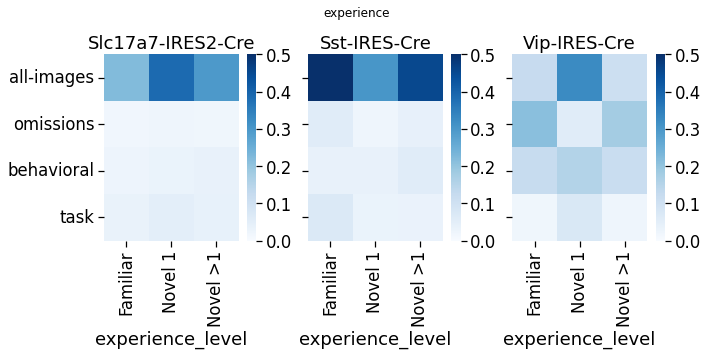

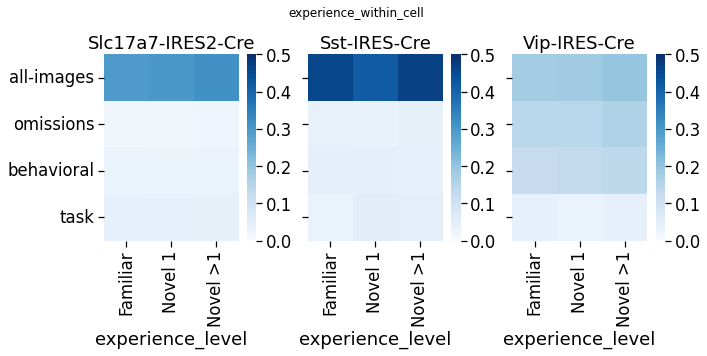

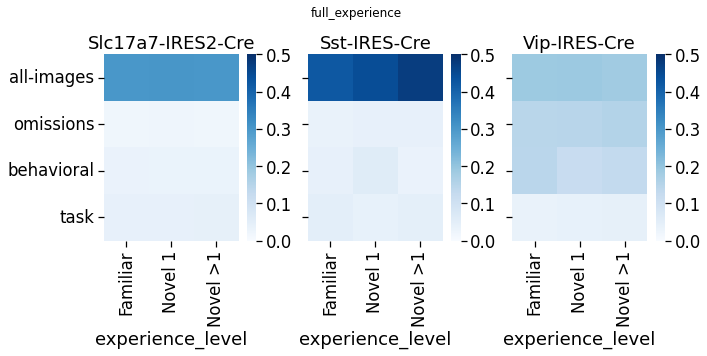

In [33]:
### pot mean of shuffled dropout scores regardless of clusters.
for shuffle_type in shuffle_types:
    fig, ax = plt.subplots(1,3, figsize = (10,5), sharey='row')
    for c, cre_line in enumerate(cre_lines):
        n_boots = shuffle_nboots[shuffle_type][cre_line][1]
        for n, n_boot in enumerate(n_boots):
            if n ==0:
                dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            else:
                dropout_scores.append(shuffle_type_df[shuffle_type][cre_line][n], ignore_index=True)
        mean_df = dropout_scores.mean().unstack()
        features = vba_clust.get_features_for_clustering()
        mean_df = mean_df.loc[features]
        ax[c] = sns.heatmap(mean_df, cmap='Blues', ax=ax[c], vmin=0, vmax=0.5)
        ax[c].set_title(cre_line)
    plt.suptitle(shuffle_type)
    plt.tight_layout()
    utils.save_figure(fig, figsize = (10,5), save_dir=save_dir, folder='', fig_title=f'mean_dropout_scores_{shuffle_type}')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4\\24_events_all_L2_optimize_by_session\\220811_all_fix1\\experience_within_cell\\Slc\\cluster_1'

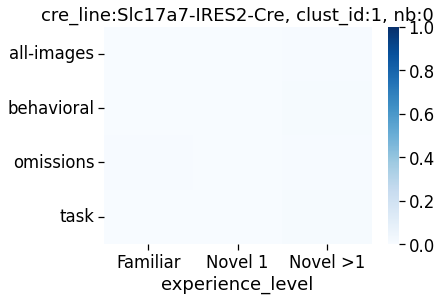

In [47]:

# This takes forever, so commenting it out unless it's needed
# plot
vmin = 0
cmap = 'Blues'

shuffle_types = shuffle_type_SSE_mapping.keys()
for shuffle_type in shuffle_types:
    
    cre_lines = shuffle_type_SSE_mapping[shuffle_type].keys()
    for cre_line in cre_lines:
        
        n_boots = shuffle_type_SSE_mapping[shuffle_type][cre_line].keys()
        for n_boot in n_boots:
            
            cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].keys()
            for cluster_id in cluster_ids:
                matched_cluster_id = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot][cluster_id]
                if matched_cluster_id !=-1:
                    dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][matched_cluster_id]

                    # plot cluster
                    fig, ax = plt.subplots()    
                    sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
                    ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

                    # save
                    this_folder = os.path.join(shuffle_type, cre_line[:3], f'cluster_{cluster_id}')
                    this_dir = os.path.join(save_dir, this_folder)
                    if not os.path.exists(this_dir):
                        os.mkdir(this_dir)    
                    plt.tight_layout()
                    figname = 'nb_{}.png'.format(n_boot)
                    fig.savefig(os.path.join(this_dir, figname))

                    plt.close('all')
            
            # plot all unmatched clusters into one folder
            # all matched cluster ids
            matched_cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].values()
            for cluster_id in cluster_ids:
                # if it is not in matched cluster ids, plot and save into unmatched folder
                if cluster_id not in matched_cluster_ids:
                    dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][cluster_id]
                    # plot cluster
                    fig, ax = plt.subplots()    
                    sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
                    ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

                    # save
                    this_folder = os.path.join(shuffle_type, cre_line[:3], 'unmatched')
                    this_dir = os.path.join(save_dir, this_folder)
                    if not os.path.exists(this_dir):
                        os.mkdir(this_dir)    
                    plt.tight_layout()
                    figname = 'nb_{}_cluster_id_{}.png'.format(n_boot, cluster_id)
                    fig.savefig(os.path.join(this_dir, figname))

                    plt.close('all')
            

In [34]:
shuffle_type_probabilities = {}
for shuffle_type in shuffle_types:
    cre_cluster_probabilities = {}
    for cre_line in cre_lines:
        SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
        cre_cluster_probabilities[cre_line] = vba_clust.compute_probabilities(SSE_mapping)
    shuffle_type_probabilities[shuffle_type] = cre_cluster_probabilities

In [35]:
for shuffle_type in shuffle_types:
    filename = 'cre_cluster_probabilities_{}_220811.pkl'.format(shuffle_type)
    vba_clust.save_clustering_results(shuffle_type_probabilities[shuffle_type], os.path.join(save_dir, filename))

In [36]:
shuffle_type_cluster_sizes = {}
for shuffle_type in shuffle_types:
    cre_cluster_sizes = {}
    for cre_line in cre_lines:
        SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
        cluster_df_shuffled = shuffle_type_labels[shuffle_type][cre_line]
        all_cluster_sizes = vba_clust.get_cluster_size_variance(SSE_mapping, cluster_df_shuffled)
        cre_cluster_sizes[cre_line] = all_cluster_sizes 
    shuffle_type_cluster_sizes[shuffle_type] = cre_cluster_sizes

In [37]:
for shuffle_type in shuffle_types:
    filename = 'cre_cluster_sizes_{}_220811.pkl'.format(shuffle_type)
    vba_clust.save_clustering_results(shuffle_type_cluster_sizes[shuffle_type], os.path.join(save_dir, filename))

### Plot proportions for matched clusters

In [38]:
cre_original_cluster_sizes = {}
for cre_line in cre_lines:
    tmp = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    cre_original_cluster_sizes[cre_line] = tmp.value_counts('cluster_id')
    

In [ ]:
# shuffle_type_cluster_sizes = {}
# for shuffle_type in shuffle_types:
#     filename = 'cre_cluster_sizes_{}_220802.pkl'.format(shuffle_type)
#     full_path = os.path.join(save_dir,filename)
#     with open(full_path, 'rb') as f:
#         shuffle_type_cluster_sizes[shuffle_type] = pkl.load(f)
#         f.close()


In [ ]:
# shuffle_type_probabilities = {}
# for shuffle_type in shuffle_types:
#     filename = 'cre_cluster_probabilities_{}_220802.pkl'.format(shuffle_type)
#     full_path = os.path.join(save_dir, filename)
#     with open(full_path, 'rb') as f:
#         shuffle_type_probabilities[shuffle_type] = pkl.load(f)
#         f.close()

In [39]:
cluster_size_difference_df = vba_clust.get_cluster_size_differece_df(cre_original_cluster_sizes, shuffle_type_cluster_sizes)

#### compute probabilities

In [40]:
shuffle_probability_df = vba_clust.get_cluster_probability_df(shuffle_type_probabilities)

c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2693: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(np.round(ax[i].get_yticks(), 1), color=color1)
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2709: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax2.get_yticks(), 1), color=color2)
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2693: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(np.round(ax[i].get_yticks(), 1), color=color1)
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2709: UserWarning: FixedForm

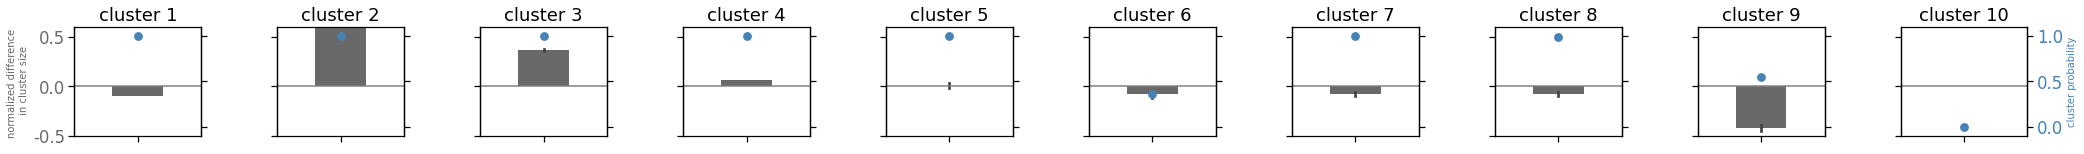

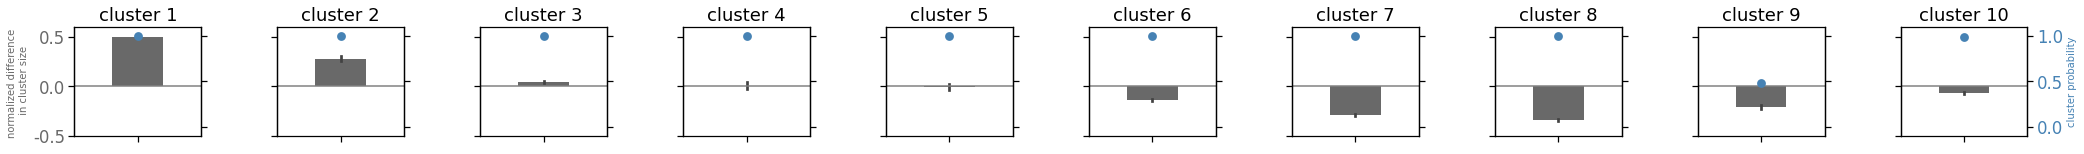

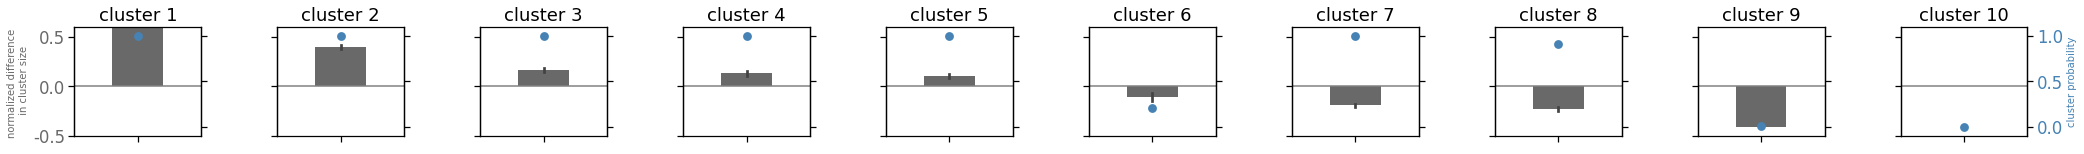

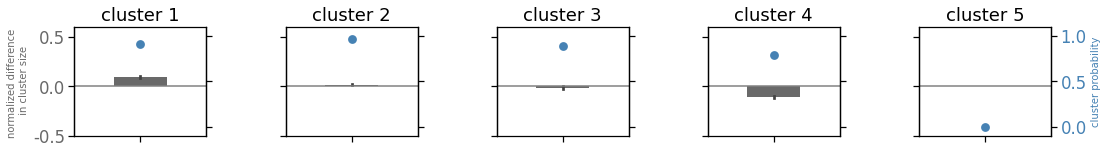

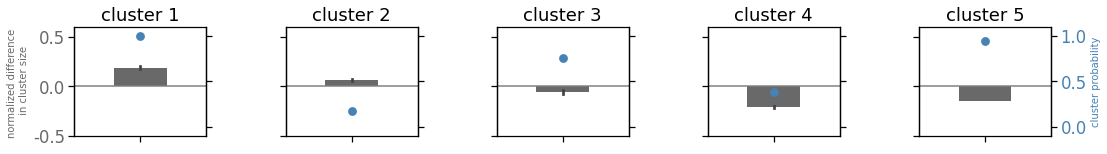

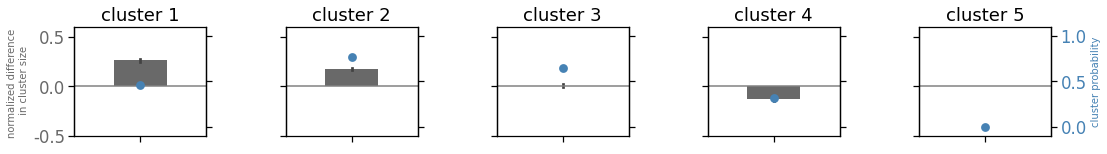

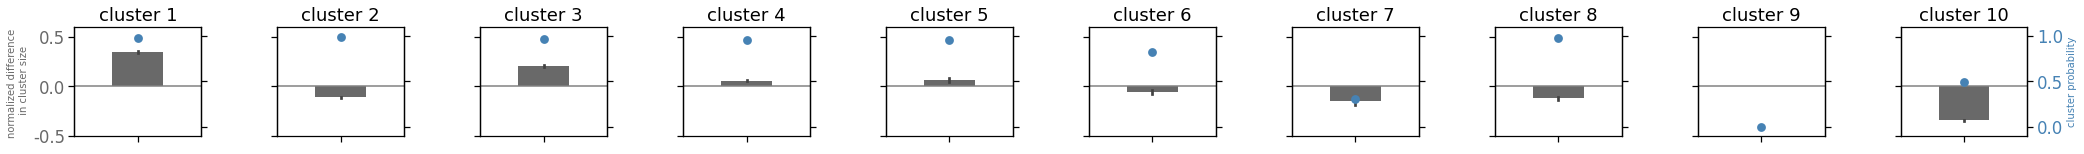

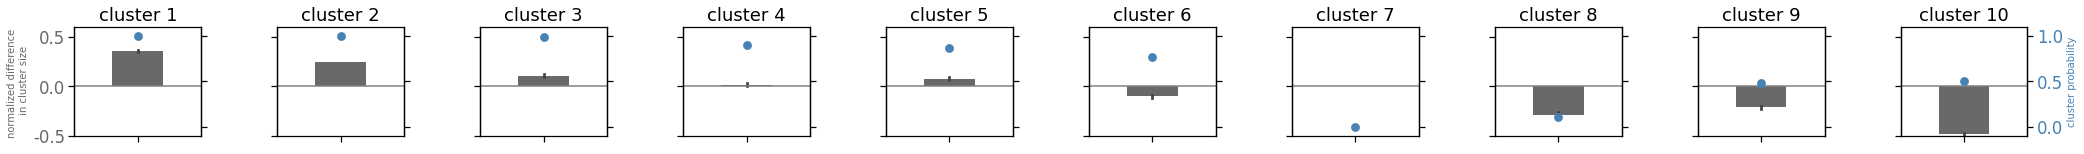

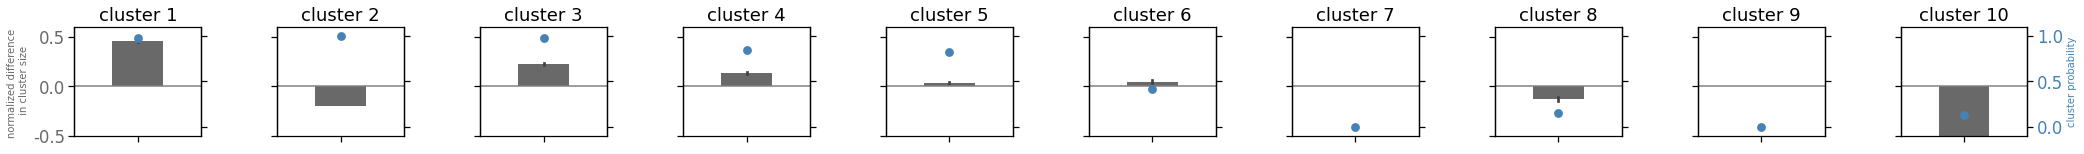

In [41]:
for cre_line in cre_lines:
    for s, shuffle_type in enumerate(shuffle_types):
        vba_clust.plot_cluster_size_and_probability(cluster_size_difference_df, 
                                                    shuffle_probability_df, 
                                                    cre_line=cre_line, 
                                                    shuffle_type=shuffle_type,
                                                   save_dir=save_dir,
                                                   folder = '')
        

#### plot mean heatmap of matched clusters

to do:
    fix this plotting function

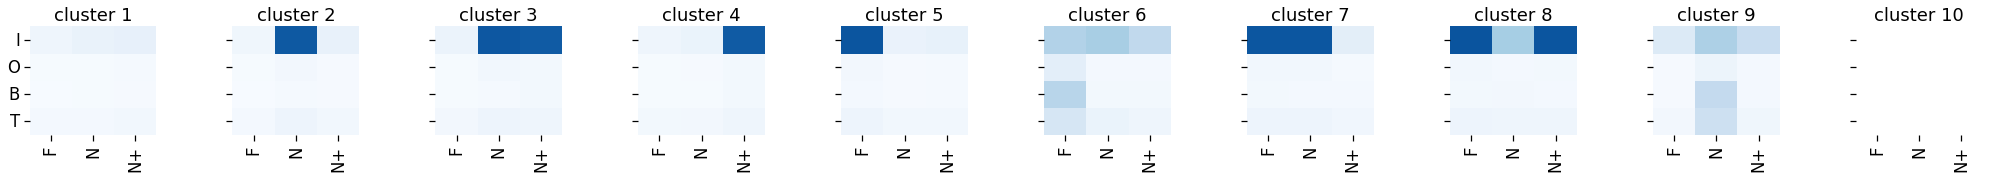

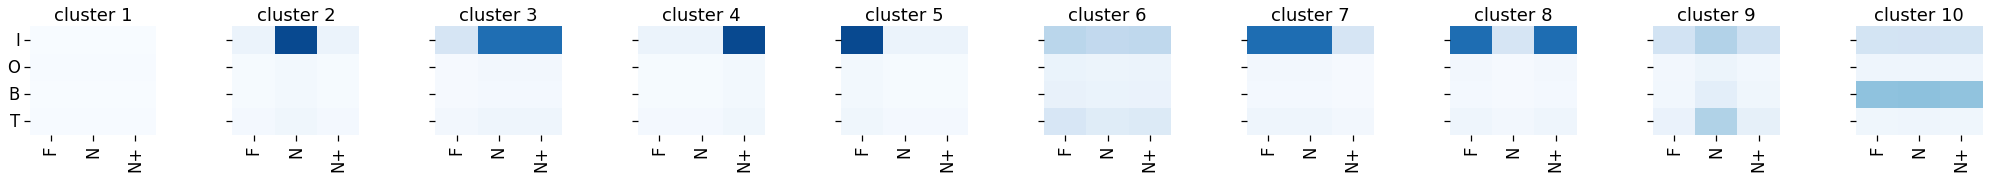

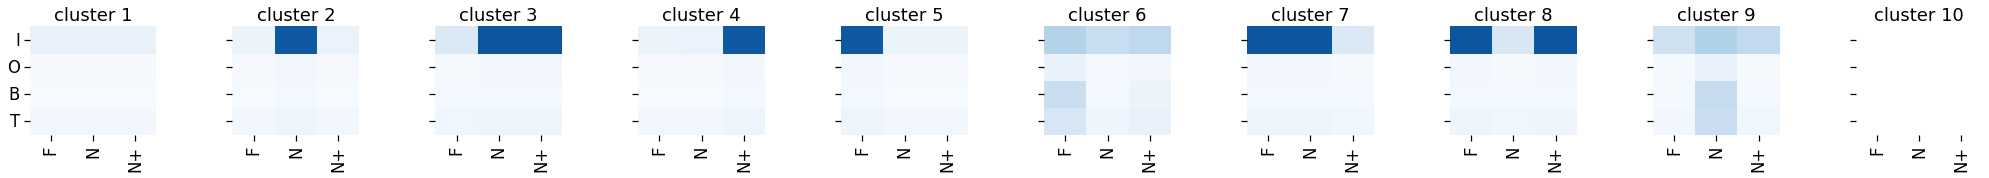

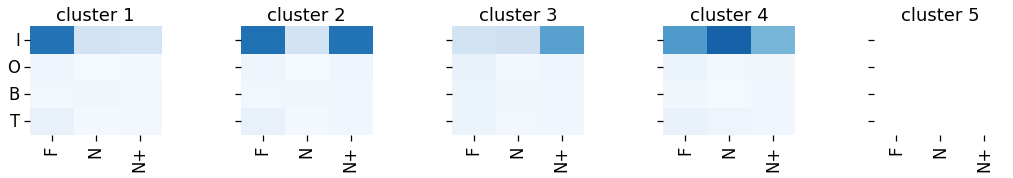

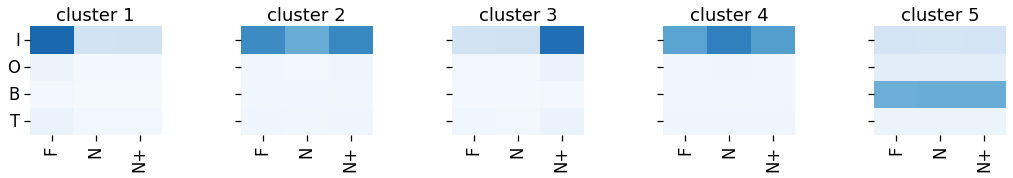

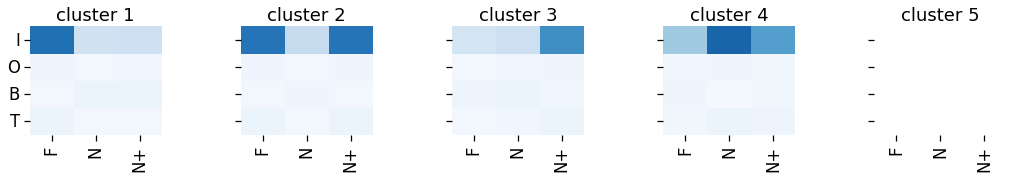

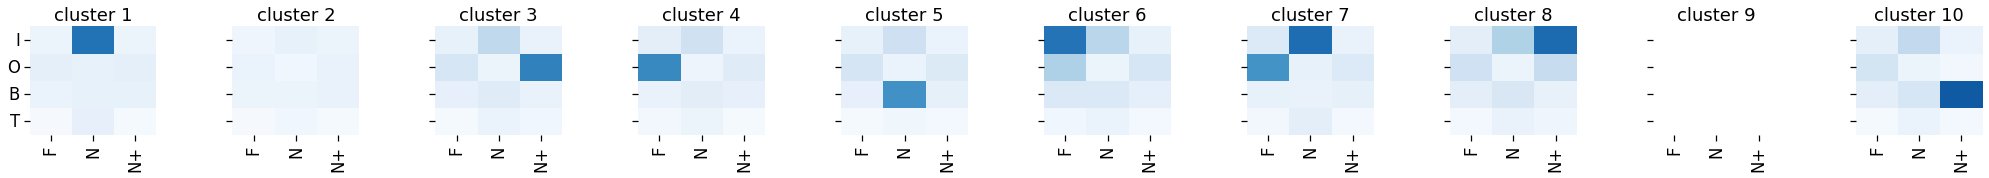

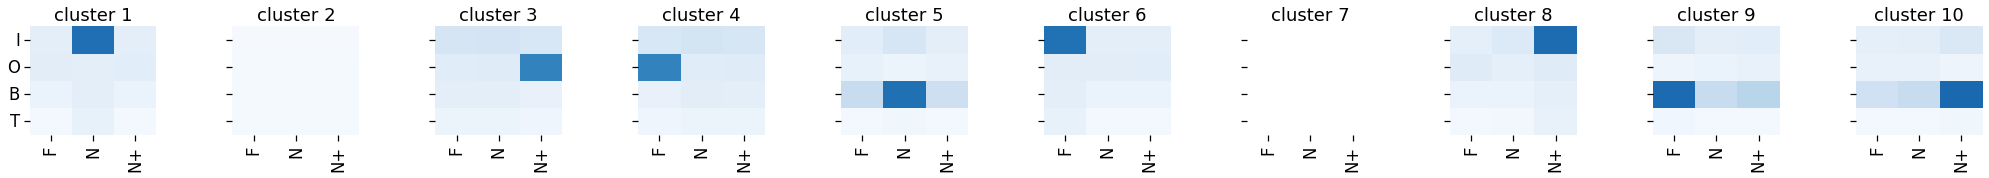

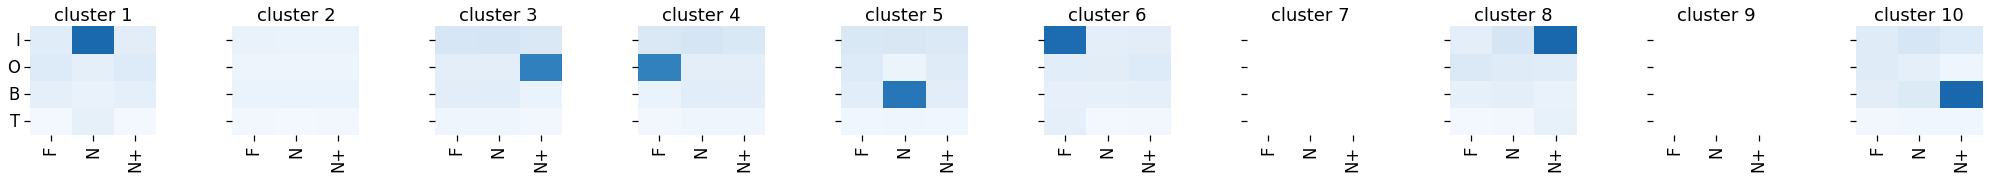

In [42]:
for cre_line in cre_lines:
    for shuffle_type in shuffle_types:
        vba_clust.plot_matched_clusters_heatmap(SSE_mapping = shuffle_type_SSE_mapping, 
                                                mean_dropout_scores_unstacked= shuffle_type_mean_dropout_scores_unstacked ,
                                                cre_line=cre_line, metric='mean',
                                                shuffle_type=shuffle_type, save_dir=save_dir, folder='')

        

In [43]:
shuffle_corr_dict = {}
for shuffle_type in shuffle_types:
    corr_dict = {}
    for cre_line in cre_lines:
        corr_dict[cre_line]= vba_clust.get_corr_for_matched_clusters_dict(shuffle_type_SSE_mapping, 
                                                       shuffle_type_mean_dropout_scores,
                                                        shuffle_type = shuffle_type,
                                                       cre_line = cre_line)
    shuffle_corr_dict[shuffle_type] = corr_dict                         

finding matched clusters for cluster id 1
computing spearman r between 369 matched clusters
finding matched clusters for cluster id 2
computing spearman r between 369 matched clusters
finding matched clusters for cluster id 3
computing spearman r between 369 matched clusters
finding matched clusters for cluster id 4
computing spearman r between 369 matched clusters
finding matched clusters for cluster id 5
computing spearman r between 369 matched clusters
finding matched clusters for cluster id 6
computing spearman r between 135 matched clusters
finding matched clusters for cluster id 7
computing spearman r between 369 matched clusters
finding matched clusters for cluster id 8
computing spearman r between 364 matched clusters
finding matched clusters for cluster id 9
computing spearman r between 202 matched clusters
finding matched clusters for cluster id 10
did not find any matched clusters for cluster id 10
finding matched clusters for cluster id 1
computing spearman r between 455 ma

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


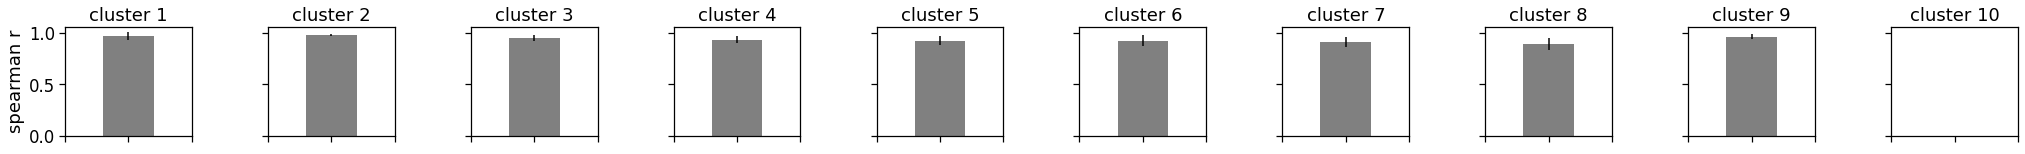

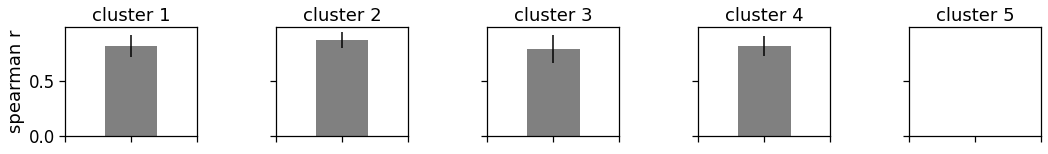

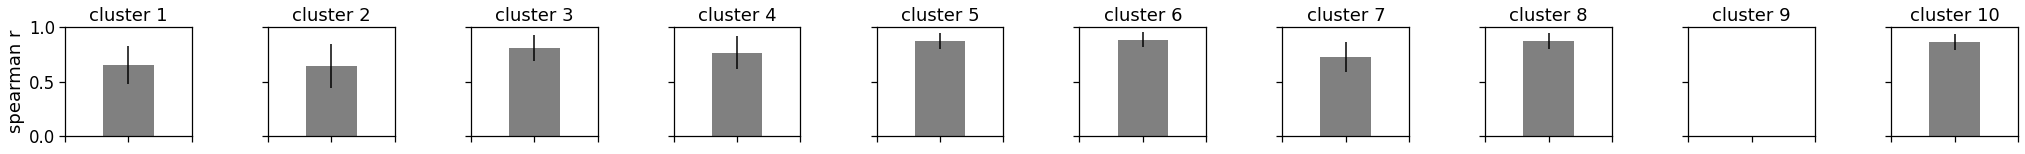

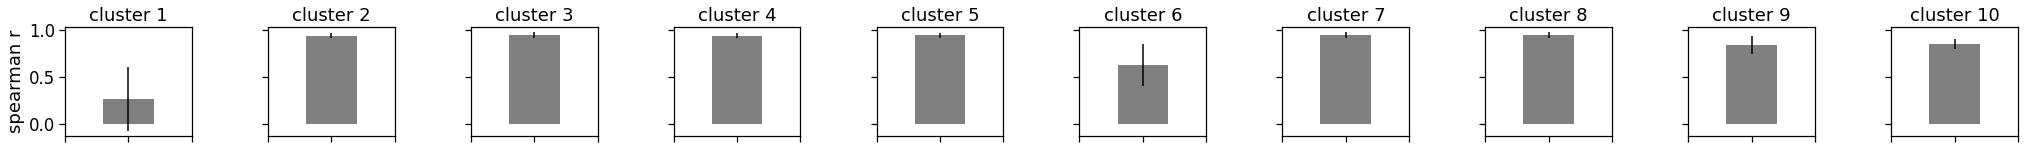

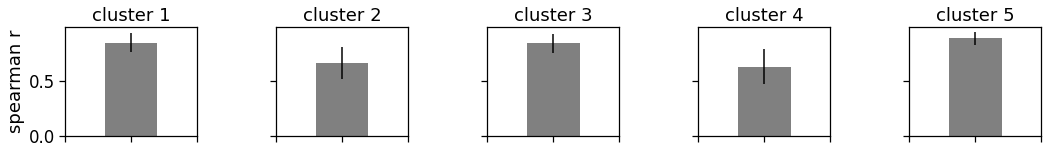

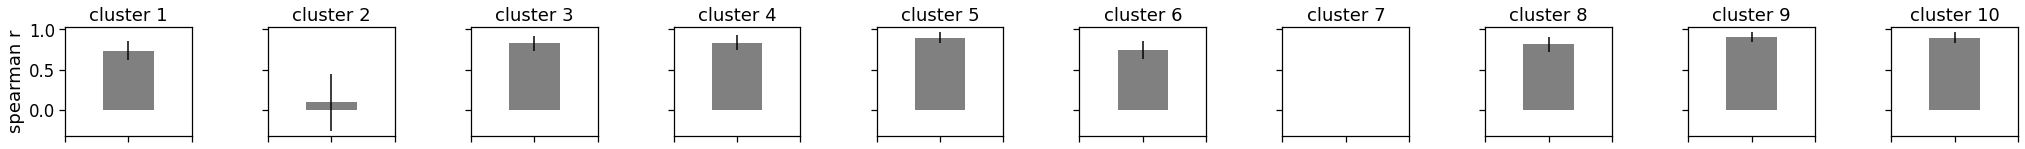

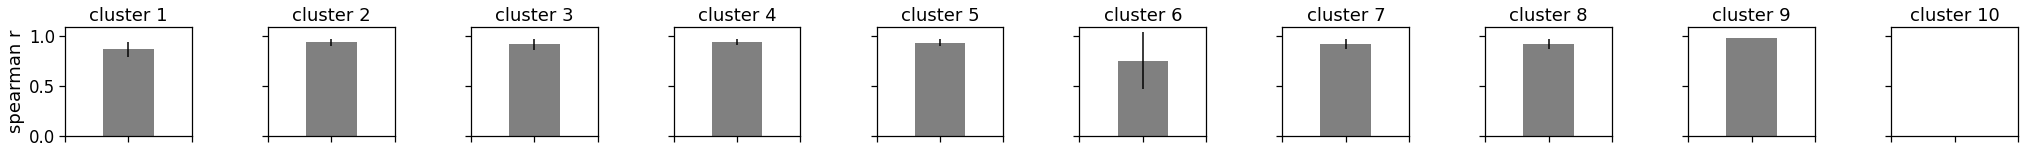

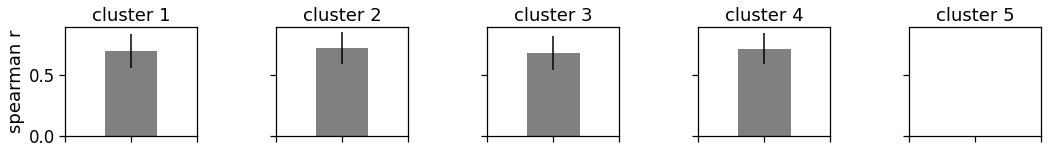

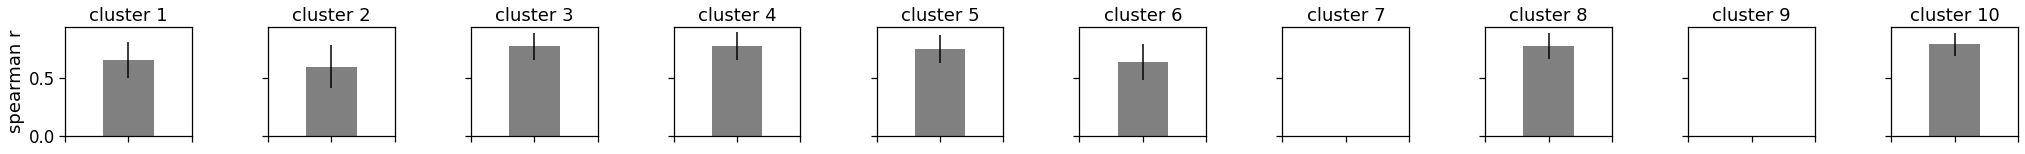

In [44]:
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        corr_dict = shuffle_corr_dict[shuffle_type][cre_line]
        n_clusters = len(corr_dict.keys())
        figsize=(3.5*n_clusters,2)
        fig, ax = plt.subplots(1,n_clusters, figsize = figsize, sharey='row')
        for i, cluster_id in  enumerate(corr_dict.keys()):
            ax[i].bar(cluster_id, corr_dict[cluster_id][0], color='Grey')
            ax[i].errorbar(cluster_id, corr_dict[cluster_id][0], corr_dict[cluster_id][1], 
                        color='k')
            ax[i].set_xticklabels([cluster_id])
            if i ==0 :
                ax[i].set_ylabel('spearman r')
            ax[i].set_xlabel('')
            ax[i].set_title(f'cluster {cluster_id}')
            ax[i].set_xticklabels('')
            ax[i].set_xlim([cluster_id-1, cluster_id+1])
            
        #plt.suptitle(cre_line + ' ' + shuffle_type)
        fig.subplots_adjust(hspace=1.2, wspace=0.6)
        utils.save_figure(fig, figsize, save_dir, '',
                          f'{shuffle_type}_spearman_within_matched_' + cre_line[:3]  )
